#EEE3548 Ass.1 (2021840150 Lee Yo-Che)

#Preparation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

Constants

In [2]:
C_m = 1         #uF/cm^2
G_Na_max = 120  #ms/cm^2
G_K_max = 36   #ms/cm^2
G_L = 0.3       #ms/cm^2

V_r_Na = -115   
V_r_K = 12      
V_r_L = -10.613 #mV
V_r = -65       #mV

delta_t = 0.01  #ms, iterating for 20000 times, or 200ms


Testing Calculation 

In [3]:
def alpha_n (delta_V):
  return (0.1 - 0.01*delta_V)/(math.exp(1-0.1*delta_V)-1)

def beta_n (delta_V):
  return 0.125/math.exp(0.125*delta_V)

def alpha_m (delta_V):
  return (2.5 - 0.1*delta_V)/(math.exp(2.5-0.1*delta_V)-1)

def beta_m (delta_V):
  return 4/math.exp(delta_V/18)

def alpha_h (delta_V):
  return 0.07/math.exp(0.05*delta_V)

def beta_h (delta_V):
  return 1/(math.exp(3-0.1*delta_V) +1)


>Function 1, get G_Na with n    
G_Na = G_Na_max * pow(n, 4)  

>Function 2, get G_K with m and h  
G_K = G_K_max * pow(m, 3) * h  


In [4]:
def g_na(n):
  return (G_Na_max*pow(n, 4))

def g_k(m, h):
  return (G_K_max*pow(m, 3)*h)

In [5]:
print(alpha_n(0))
print(beta_n(0))
print(alpha_m(0))
print(beta_m(0))
print(alpha_h(0))
print(beta_h(0))


0.05819767068693265
0.125
0.22356372458463003
4.0
0.07
0.04742587317756678


#Model Buildup

In [6]:
class Model:

    class Gate:
        alpha, beta, state = 0, 0, 0

        def update(self, deltaTms):
            alphaState = self.alpha * (1-self.state)
            betaState = self.beta * self.state
            self.state += deltaTms * (alphaState - betaState)

        def setInfiniteState(self):
            self.state = self.alpha / (self.alpha + self.beta)

    V_r_Na, V_r_K, V_r_L = 115, -12, 10.613
    gNa, gK, gL = 120, 36, 0.3
    m, n, h = Gate(), Gate(), Gate()
    Cm = 1

    def __init__(self, startingVoltage=0):
        self.Vm = startingVoltage
        self._UpdateGateTimeConstants(startingVoltage)
        self.m.setInfiniteState()
        self.n.setInfiniteState()
        self.n.setInfiniteState()

    def _UpdateGateTimeConstants(self, Vm):
        self.n.alpha = 0.01 * ((10-Vm) / (np.exp((10-Vm)/10)-1))
        self.n.beta = 0.125 * np.exp(-Vm / 80)
        self.m.alpha = 0.1*((25-Vm) / (np.exp((25-Vm)/10)-1))
        self.m.beta = 4*np.exp(-Vm/18)
        self.h.alpha = 0.07*np.exp(-Vm/20)
        self.h.beta = 1/(np.exp((30-Vm)/10)+1)

    def _UpdateCellVoltage(self, Current, deltaTms):
        """calculate channel currents using the latest gate time constants"""
        self.INa = np.power(self.m.state, 3) * self.gNa * self.h.state*(self.Vm-self.V_r_Na)
        self.IK = np.power(self.n.state, 4) * self.gK * (self.Vm-self.V_r_K)
        self.IL = self.gL * (self.Vm-self.V_r_L)
        Isum = Current - self.INa - self.IK - self.IL
        self.Vm += deltaTms * Isum / self.Cm

    def _UpdateGateStates(self, deltaTms):
        """calculate new channel open states using latest Vm"""
        self.n.update(deltaTms)
        self.m.update(deltaTms)
        self.h.update(deltaTms)

    def iterate(self, Current, deltaTms):
        self._UpdateGateTimeConstants(self.Vm)
        self._UpdateCellVoltage(Current, deltaTms)
        self._UpdateGateStates(deltaTms)

In [7]:
class Sim:

    def __init__(self, model):
        self.model = model
        self.CreateArrays(0, 0)
        pass

    def CreateArrays(self, pointCount, deltaTms):
        self.times = np.arange(pointCount) * deltaTms
        self.Vm = np.empty(pointCount)
        self.INa = np.empty(pointCount)
        self.IK = np.empty(pointCount)
        self.IL = np.empty(pointCount)
        self.StateN = np.empty(pointCount)
        self.StateM = np.empty(pointCount)
        self.StateH = np.empty(pointCount)

    def Run(self, stimulusWaveform, stepSizeMs):        
        assert isinstance(stimulusWaveform, np.ndarray)
        self.CreateArrays(len(stimulusWaveform), stepSizeMs)
        for i in range(len(stimulusWaveform)):
            self.model.iterate(stimulusWaveform[i], stepSizeMs)
            self.Vm[i] = self.model.Vm
            self.INa[i] = self.model.INa
            self.IK[i] = self.model.IK
            self.IL[i] = self.model.IL
            self.StateH[i] = self.model.h.state
            self.StateM[i] = self.model.m.state
            self.StateN[i] = self.model.n.state        

>setupMod() creates the model with different input current and generate a sim object  
>showmod() plot the data in the sim object into graphs

In [20]:
def setupMod(current):
  model = Model()
  model.gNa = 120  
  model.gK = 36  
  model.V_r_K = -12 
  sim = Sim(model)
  stim = []
  stim = np.zeros(20000)
  stim[2000:] = current
  sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)
  return sim

def showMod(sim, current):
  stim = np.zeros(20000)
  stim[2000:] = current
  plt.figure(figsize=(10, 8))

  ax1 = plt.subplot(411)
  ax1.plot(sim.times, sim.Vm - 70, color='b')
  plt.xticks(range(0,220,20))
  ax1.set_ylabel("Potential (mV)")
  ax1.set_title("HH Model with Input Current {} µA/cm²".format(current))

  ax2 = plt.subplot(412, sharex=ax1)
  ax2.plot(sim.times, stim, color='r')
  ax2.set_ylabel("Input Current (µA/cm²)")

  ax3 = plt.subplot(413, sharex=ax1)
  ax3.plot(sim.times, sim.StateH, label='h')
  ax3.plot(sim.times, sim.StateM, label='m')
  ax3.plot(sim.times, sim.StateN, label='n')
  ax3.legend()

  ax4 = plt.subplot(414, sharex=ax1)
  ax4.plot(sim.times, sim.INa, label='Na')
  ax4.plot(sim.times, sim.IK, label='K')
  ax4.plot(sim.times, sim.IL, label='L')
  ax4.set_ylabel("Current (µA/cm²)")
  ax4.set_xlabel("Time (ms)")
  ax4.legend()

  plt.tight_layout() 
  return plt

#Simulations

##5-1 Simulation with different input

a) Generate the graph of simulation result with input current = 2 (µA/cm²)

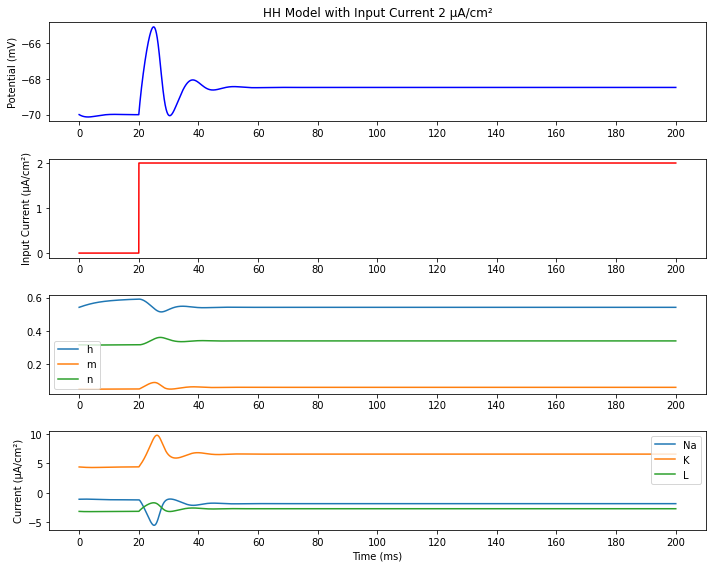

In [21]:
model = setupMod(2)
plt = showMod(model, 2)
plt.show()

b) Generate the graph of simulation result with input current = 6 (µA/cm²)

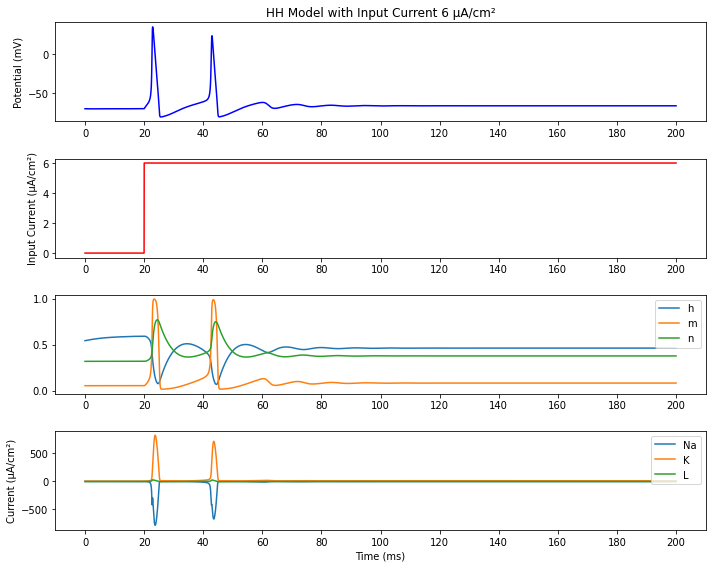

In [22]:
model = setupMod(6)
plt = showMod(model, 6)
plt.show()

c) Generate the graph of simulation result with input current = 10 (µA/cm²)

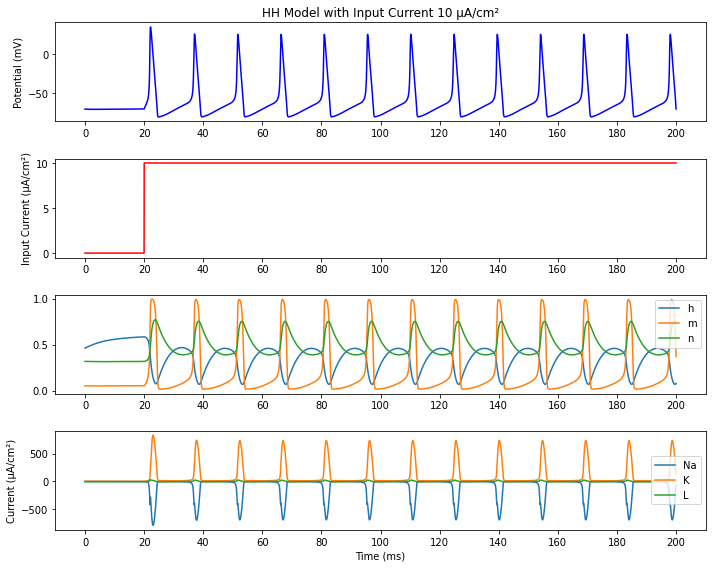

In [23]:
model = setupMod(10)
plt = showMod(model, 10)
plt.show()

###Checking the threashold

Between 6 and 10

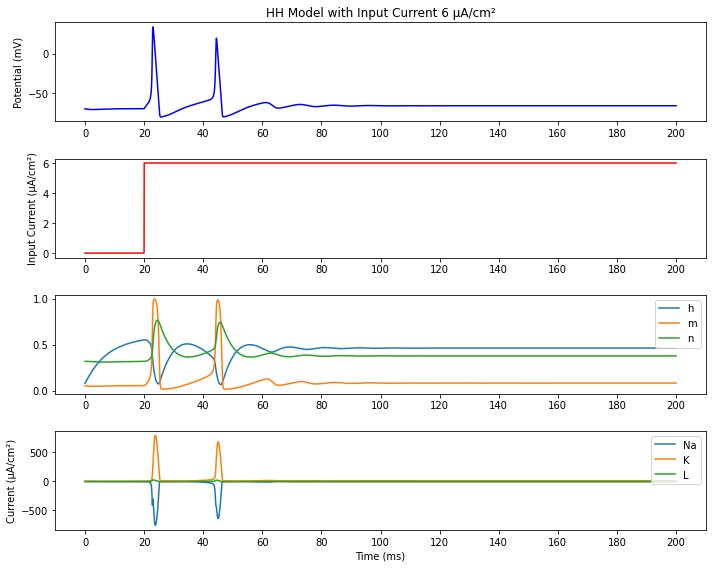

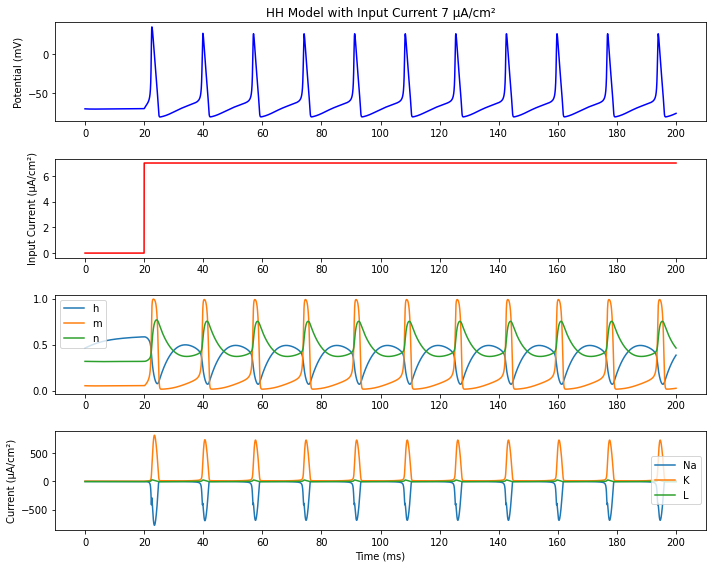

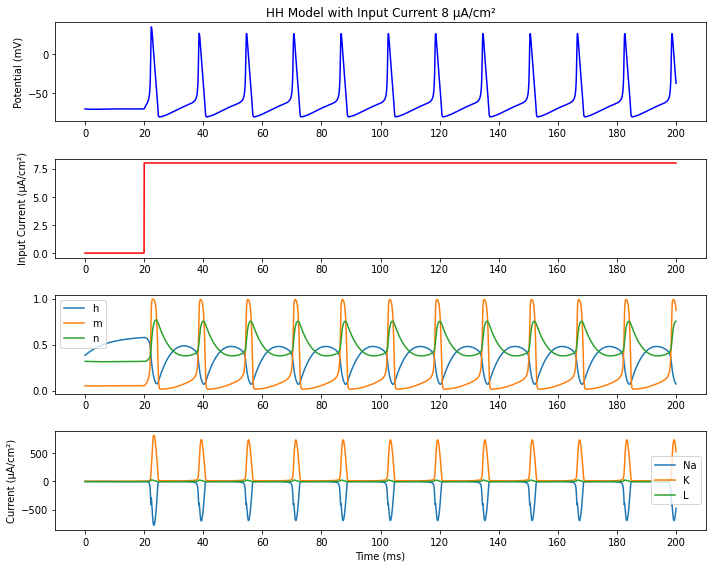

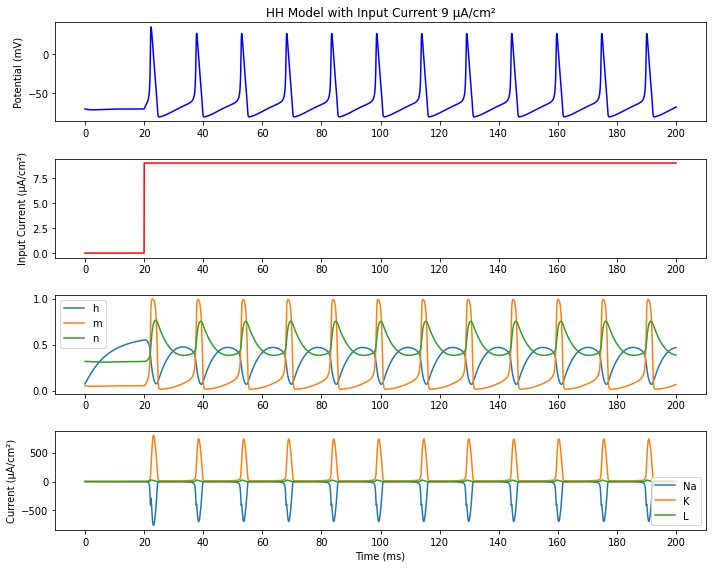

In [24]:
for i in range (6, 10):
  model = setupMod(i)
  plt = showMod(model, i)
  plt.show()

Between 6 and 7

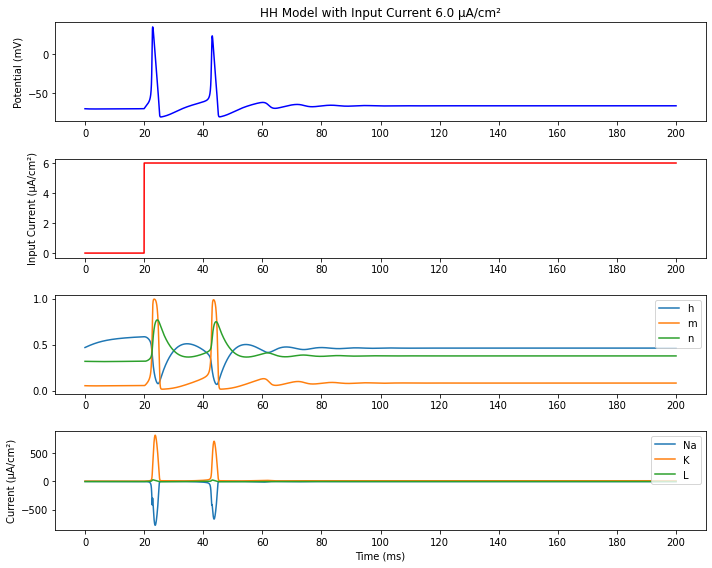

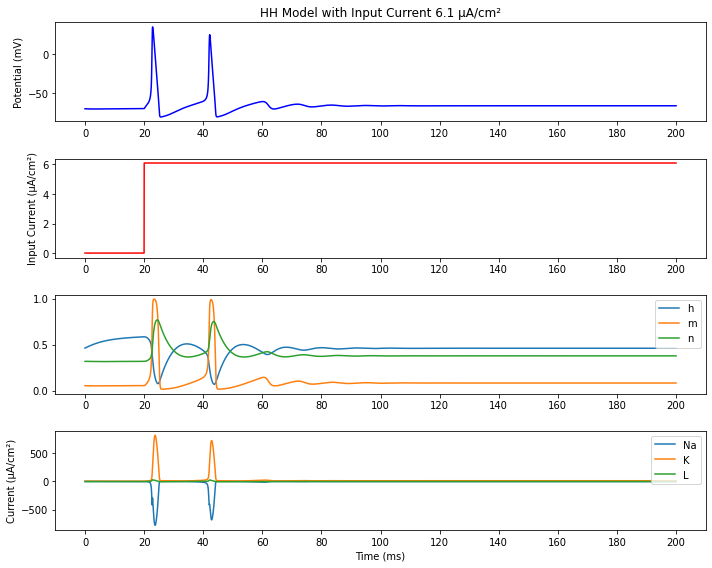

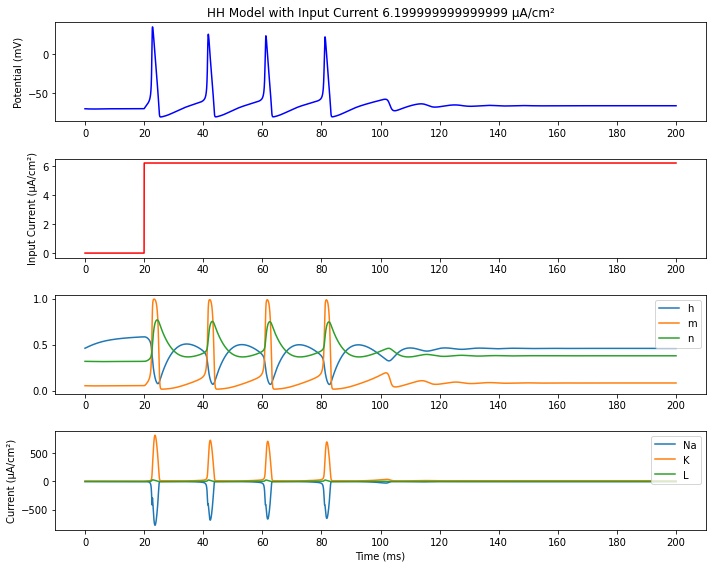

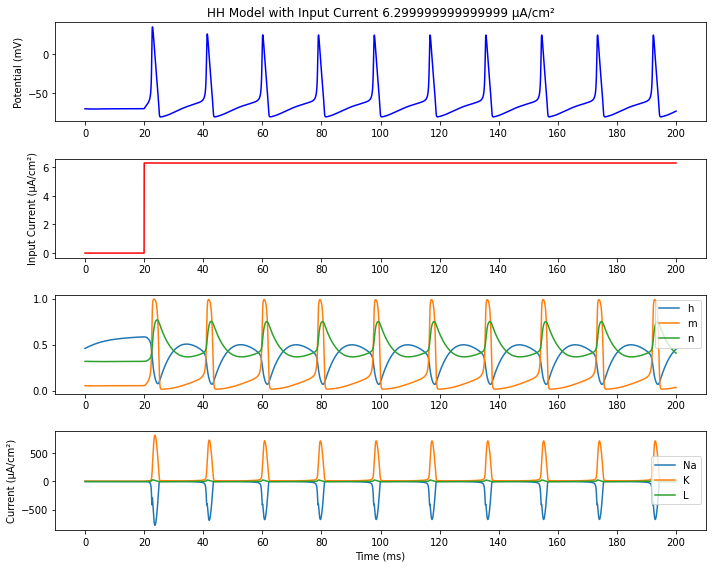

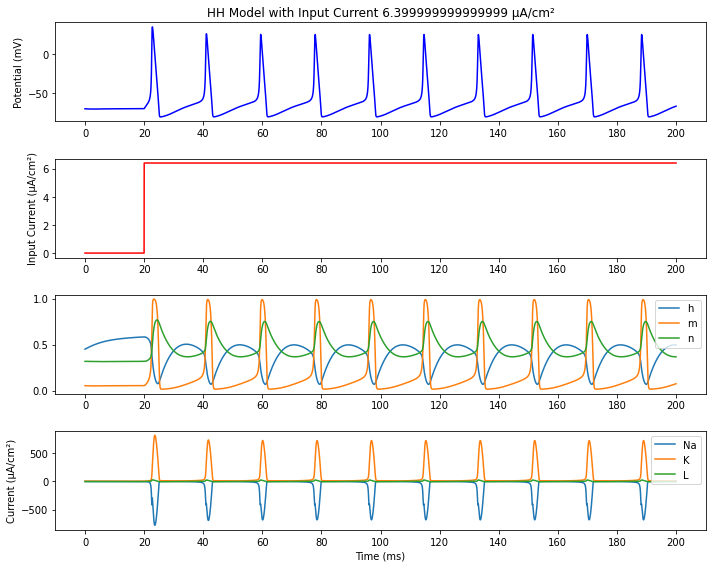

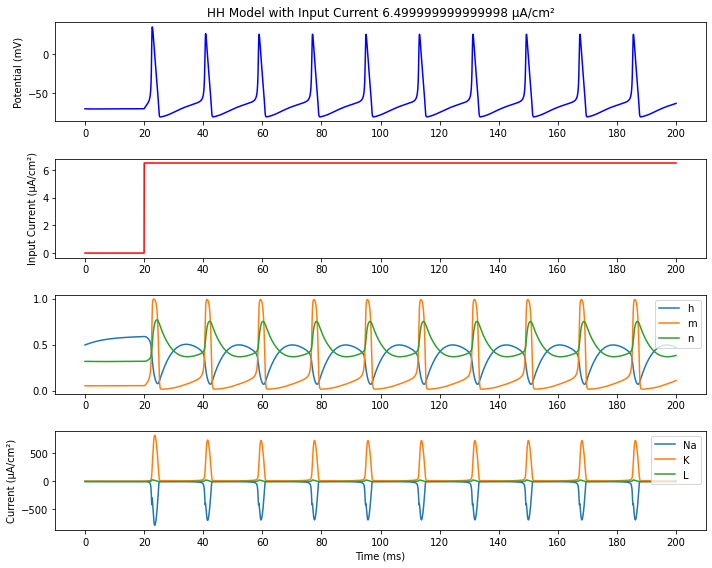

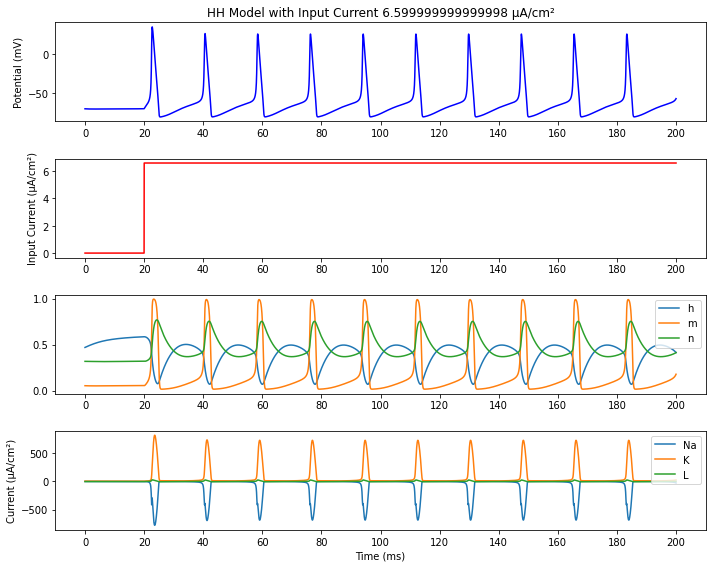

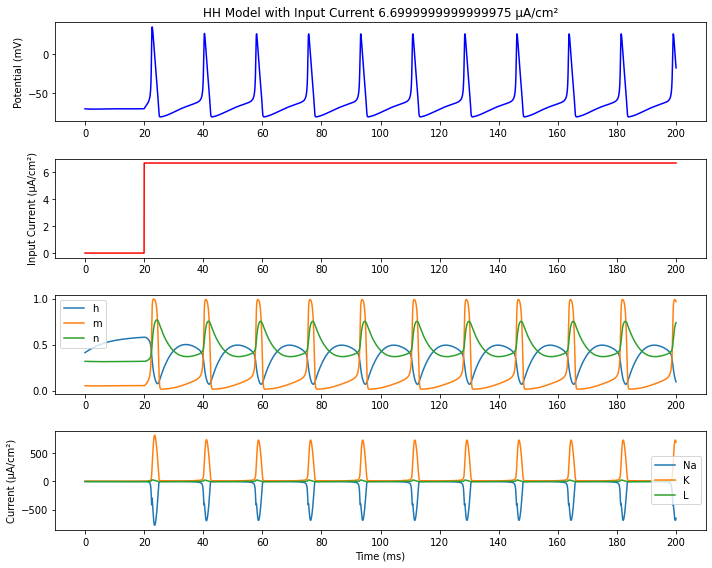

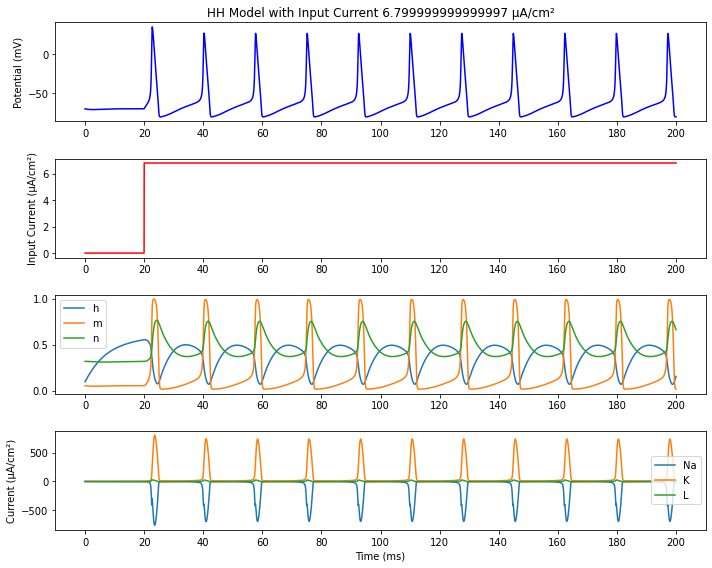

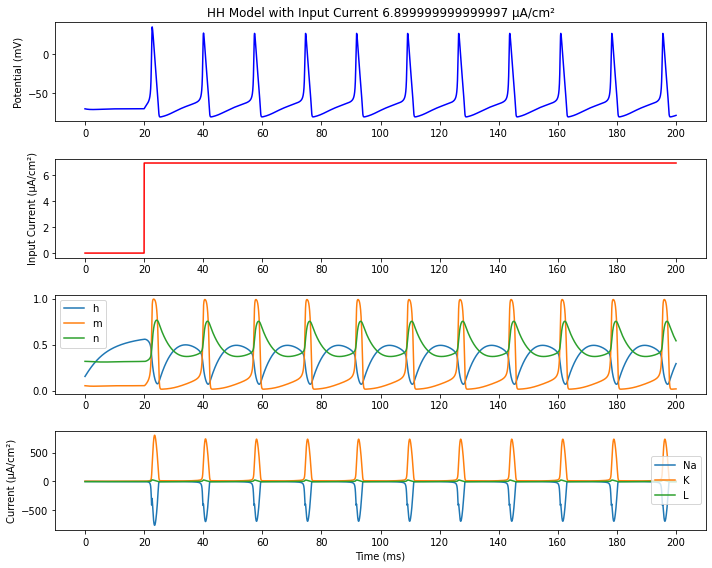

In [25]:
for i in np.arange (6, 7, 0.1):
  model = setupMod(i)
  plt = showMod(model, i)
  plt.show()

Between 6.2 and 6.3

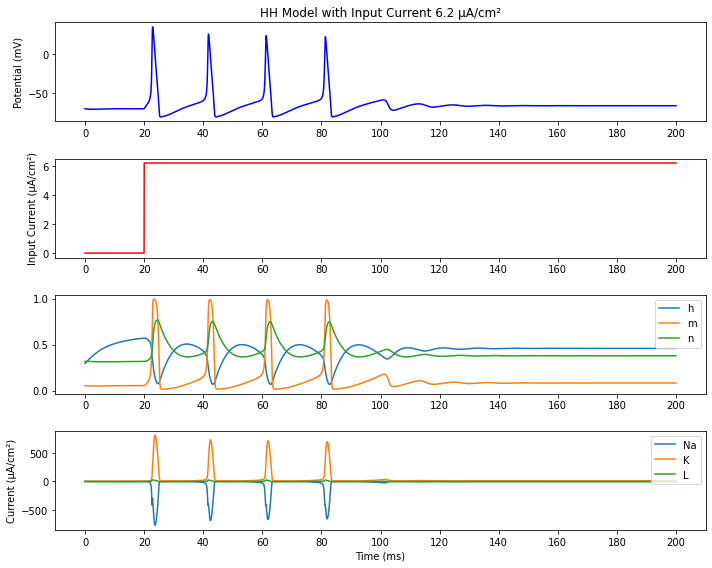

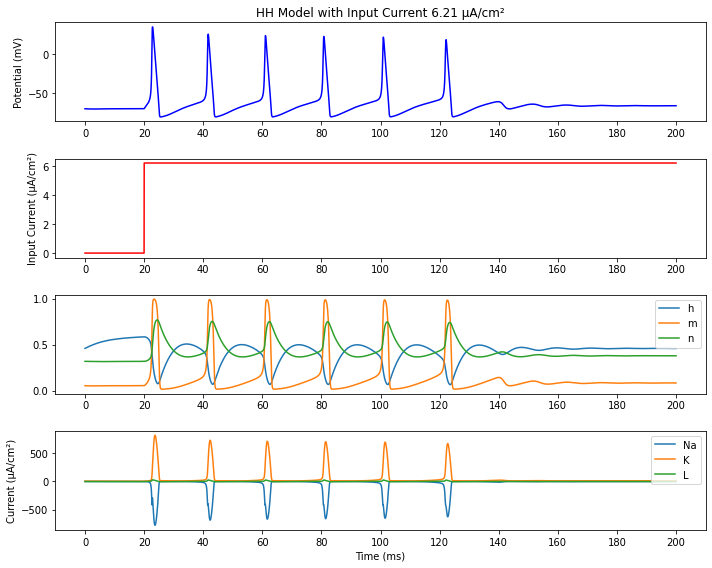

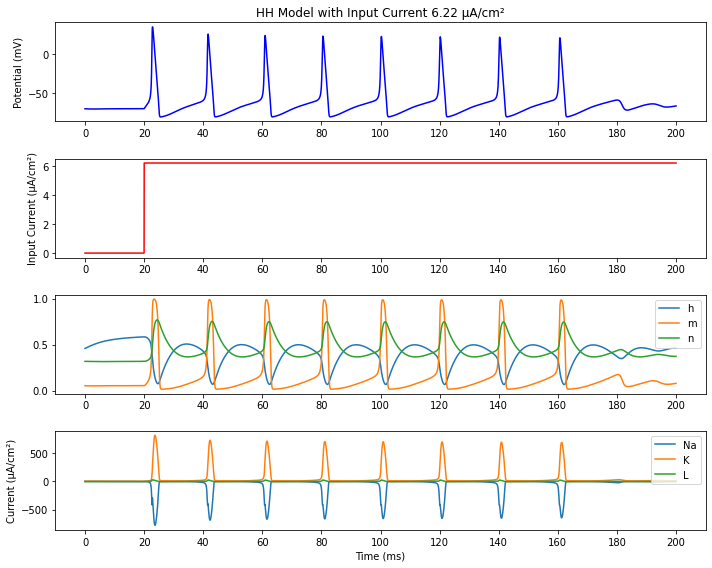

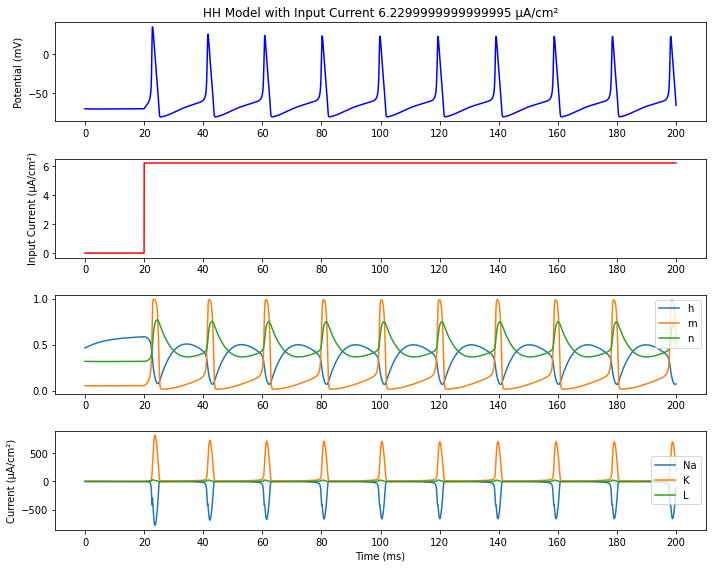

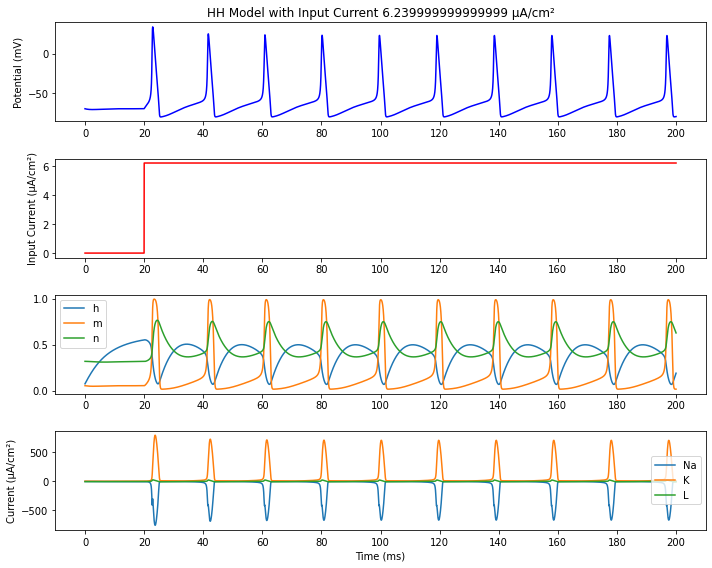

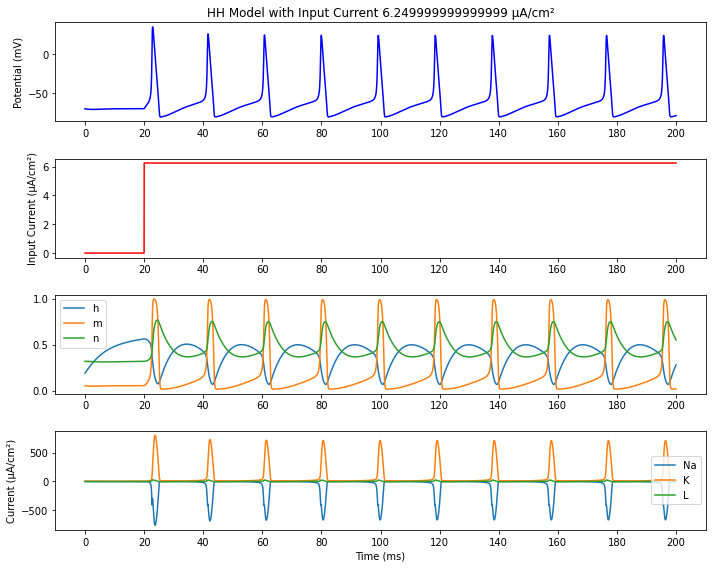

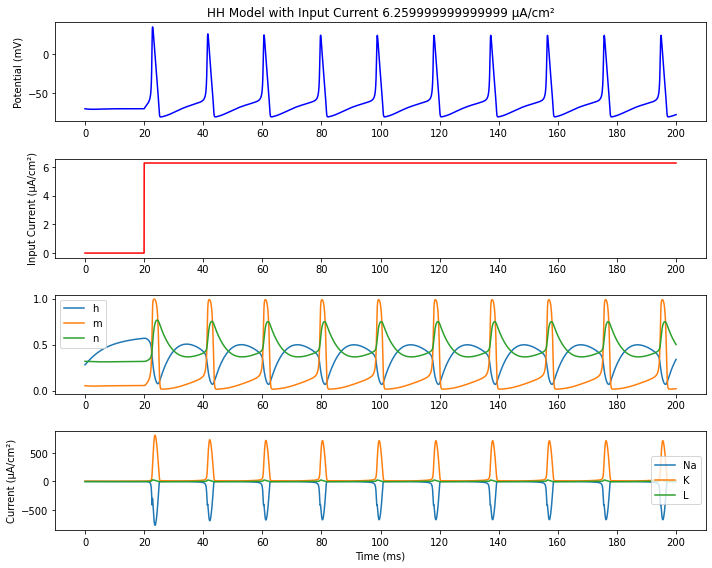

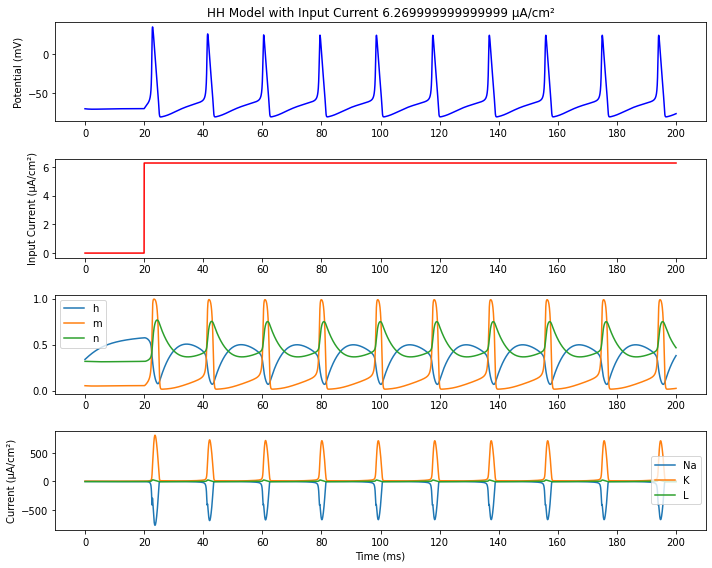

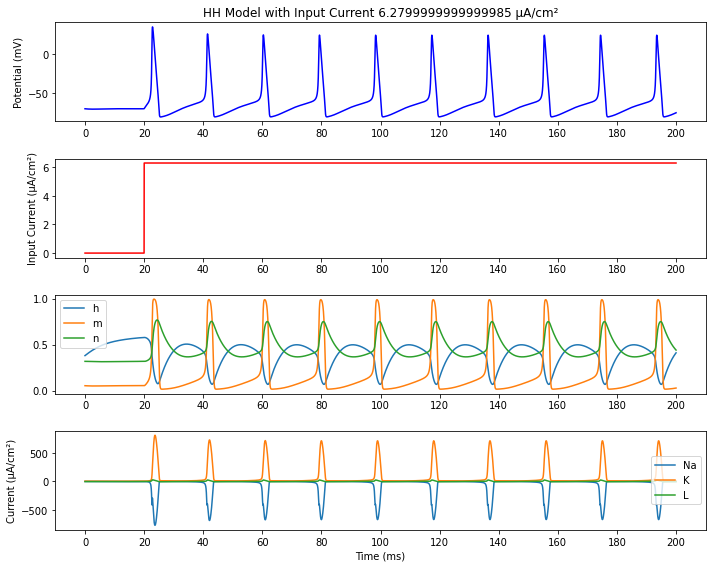

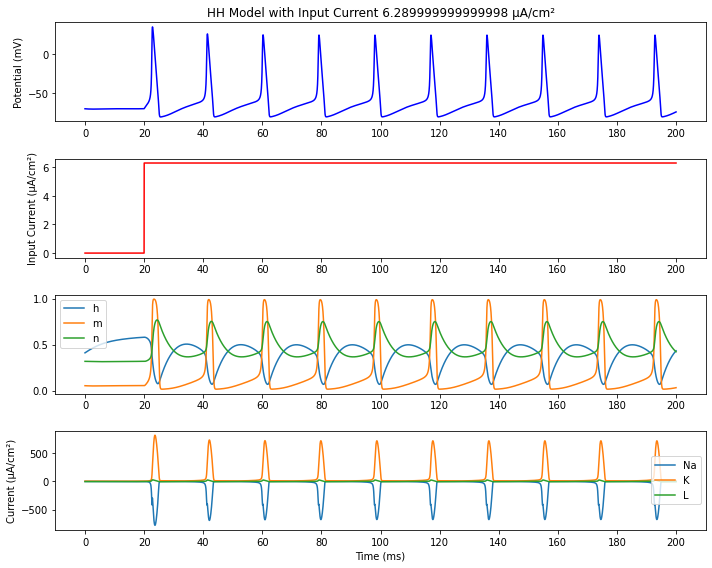

In [26]:
for i in np.arange (6.2, 6.3, 0.01):
  model = setupMod(i)
  plt = showMod(model, i)
  plt.show()

The threashold is between 6.22 and 6.23

##5-3

Modify the function setmod(), reducing the sodium concentration by a factor of 2 

In [29]:
def setupMod(current):
  model = Model()
  model.gNa = 60  
  model.gK = 36  
  model.V_r_K = -12 
  sim = Sim(model)

  stim = []
  stim = np.zeros(20000)
  stim[2000:] = current
  sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)
  return sim


Generate the graph of simulation result with input current = 10 (µA/cm²)

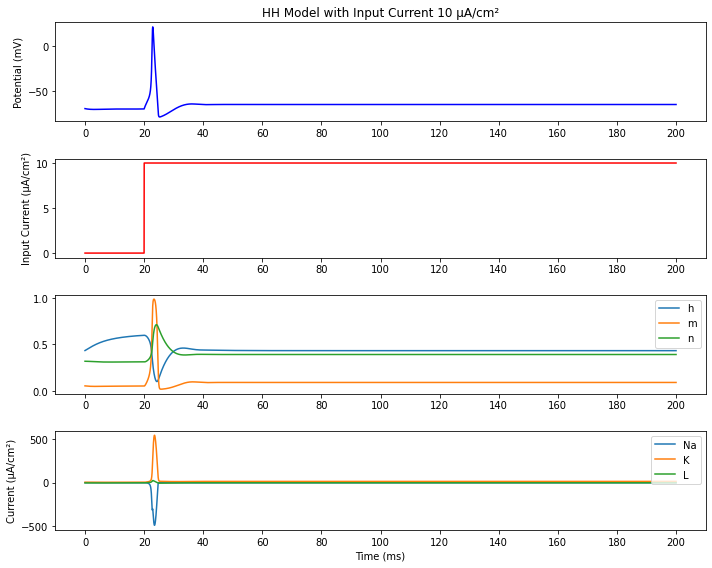

In [30]:
model = setupMod(10)
plt = showMod(model, 10)
plt.show()

###5-5

Cnange in GNa by 30%

In [31]:
def setupMod(current):
  model = Model()
  model.gNa = 120*1.3   
  model.gK = 36  
  model.V_r_K = -12 
  sim = Sim(model)
  stim = []
  stim = np.zeros(20000)
  stim[2000:] = current
  sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)
  return sim


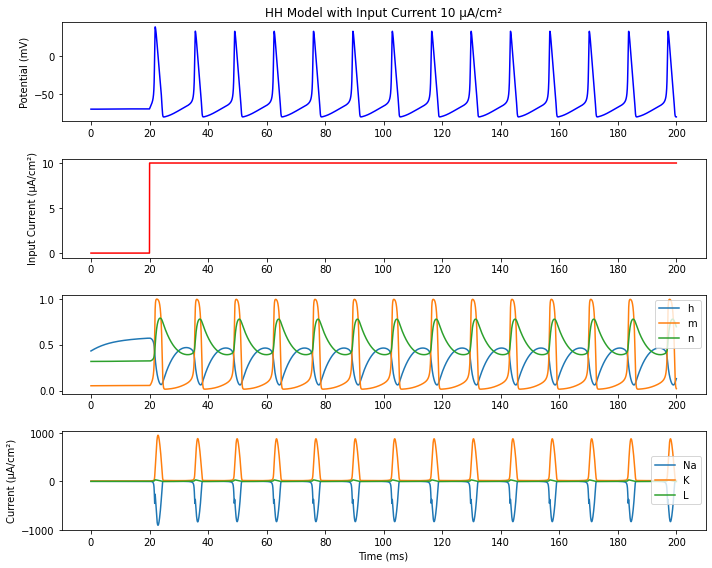

In [32]:
model = setupMod(10)
plt = showMod(model, 10)
plt.show()

Cnange in GNa by -30%

In [33]:
def setupMod(current):
  model = Model()
  model.gNa = 120*0.7
  model.gK = 36  
  model.V_r_K = -12 
  sim = Sim(model)
  stim = []
  stim = np.zeros(20000)
  stim[2000:] = current
  sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)
  return sim


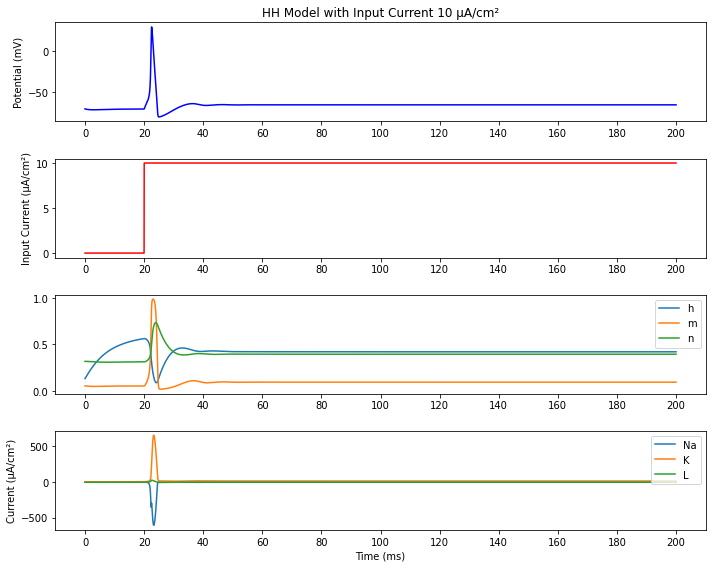

In [34]:
model = setupMod(10)
plt = showMod(model, 10)
plt.show()

Cnange in GK by 30%

In [36]:
def setupMod(current):
  model = Model()
  model.gNa = 120   
  model.gK = 36*1.3  
  model.V_r_K = -12 
  sim = Sim(model)

  stim = []
  stim = np.zeros(20000)
  stim[2000:] = current
  sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)
  return sim


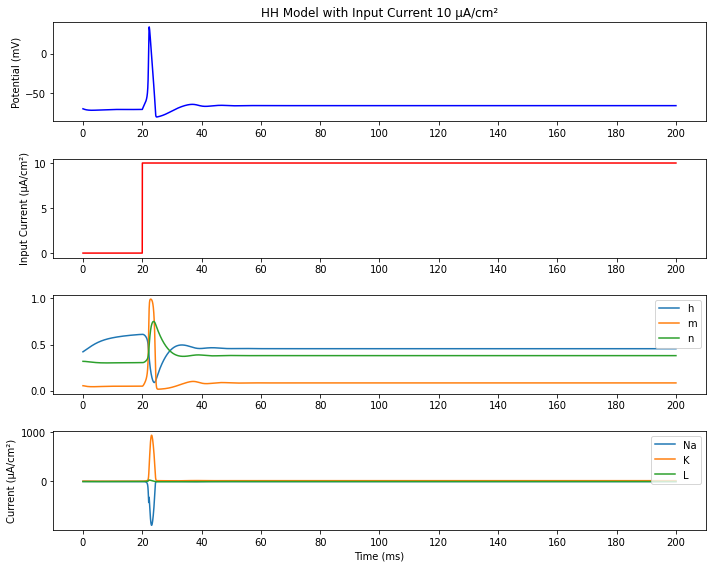

In [37]:
model = setupMod(10)
plt = showMod(model, 10)
plt.show()

Cnange in GNa by -30%

In [38]:
def setupMod(current):
  model = Model()
  model.gNa = 120   
  model.gK = 36*0.7  
  model.V_r_K = -12 
  sim = Sim(model)

  stim = []
  stim = np.zeros(20000)
  stim[2000:] = current  
  sim.Run(stimulusWaveform=stim, stepSizeMs=0.01)
  return sim


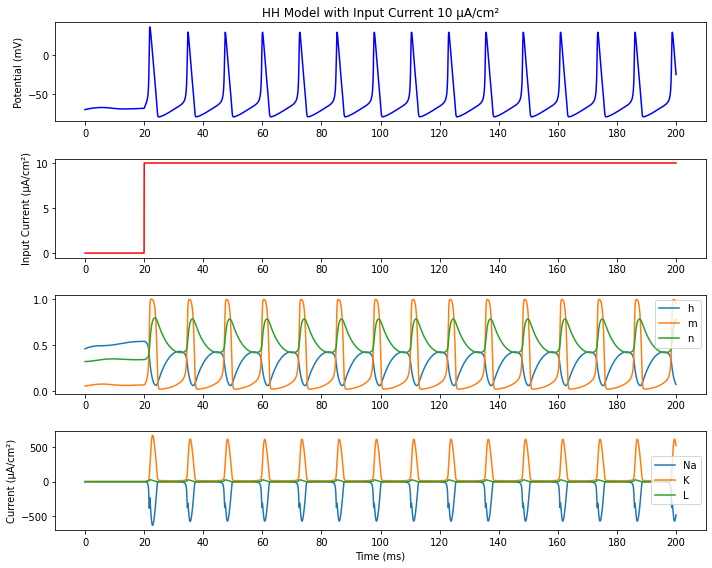

In [39]:
model = setupMod(10)
plt = showMod(model, 10)
plt.show()